## Import Modules

In [665]:
import json
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
from datetime import datetime
from scipy.optimize import minimize

## Define Functions

In [666]:
def replacer(l,target_val=0,replace_val=np.NaN,repeat_max=5):
    #repeat_max = n (consecutive 0s over 10 times will be replaced with NAs)
    counter = 0
    new_l = []
    for e in l:
        if e == target_val: counter += 1
        else:
            counter = 0

        if counter > repeat_max:
            new_l.append(replace_val)
        else:
            new_l.append(e)

    return new_l

In [667]:
from typing import Iterable 
#from collections imtmp Iterable                            

def flatten(items):
    for x in items:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            for sub_x in flatten(x):
                yield sub_x
        else:
            yield x

## Import Data

In [668]:
df_price = pd.read_excel("Price.xlsx", index_col=0) 
df_price.index = df_price.index.to_series().dt.to_period('M')
df_price

,Mnemonic,Close
Date,,
2019-12,4SI:XJSE:EQU,32.0
2019-11,4SI:XJSE:EQU,20.0
2019-10,4SI:XJSE:EQU,20.0
2019-09,4SI:XJSE:EQU,20.0
2019-08,4SI:XJSE:EQU,18.0
...,...,...
2009-05,ZED:XJSE:EQU,144.0
2009-04,ZED:XJSE:EQU,148.0
2009-03,ZED:XJSE:EQU,140.0


In [669]:
df_size = pd.read_excel("Market Capitalizations.xlsx", usecols=[0,2,3], index_col=1)
df_size.index = df_size.index.to_series().dt.to_period('M')
df_size

,Mnemonic,Market Cap
Date,,
2019-12,4SI:XJSE:EQU,253217582.0
2019-11,4SI:XJSE:EQU,158260989.0
2019-10,4SI:XJSE:EQU,158260989.0
2019-09,4SI:XJSE:EQU,158260989.0
2019-08,4SI:XJSE:EQU,142434890.0
...,...,...
2009-05,ZED:XJSE:EQU,880279665.0
2009-04,ZED:XJSE:EQU,904687478.0
2009-03,ZED:XJSE:EQU,855785452.0


In [670]:
df_MR = pd.read_excel("J203T Price.xlsx", usecols=[0,1], index_col=0)
df_MR

,J203T
Dates,
2000-01-04,694.664
2000-01-05,687.378
2000-01-06,688.400
2000-01-07,705.859
2000-01-10,729.218
...,...
2020-02-24,8332.211
2020-02-25,8321.271
2020-02-26,8357.358


In [671]:
df_RF = pd.read_excel("91days T-Bill rate.xlsx", index_col=0)
df_RF


,Value
Date,
2000-01-05,10.71
2000-01-06,10.71
2000-01-07,10.56
2000-01-10,10.56
2000-01-11,10.56
...,...
2019-12-25,7.19
2019-12-26,7.19
2019-12-27,7.16


## Sorting Data

Reform price data frame

In [672]:
tmp = pd.DataFrame()
labels = []
n = int((2019-2009+1)*12)

for i in range(int(len(df_price)/n)): 
    price = pd.DataFrame(df_price.iloc[n*i:n*(i+1),1])
    name = df_price.iloc[range(1,len(df_price),n)[i],0]
    tmp = pd.concat([tmp,price], axis=1)
    labels.append(name)
    tmp.columns = [labels]


In [673]:
df_price = tmp
# reorder the date of price data
df_price = df_price.sort_index(ascending=True)
df_price.columns = df_price.columns.get_level_values(0).values
df_price

,4SI:XJSE:EQU,ABG:XJSE:EQU,APF:XJSE:EQU,ACS:XJSE:EQU,AIP:XJSE:EQU,ADR:XJSE:EQU,AVL:XJSE:EQU,ADH:XJSE:EQU,AFE:XJSE:EQU,ANI:XJSE:EQU,...,VKE:XJSE:EQU,VUN:XJSE:EQU,WEZ:XJSE:EQU,WEA:XJSE:EQU,WBO:XJSE:EQU,WHL:XJSE:EQU,WKF:XJSE:EQU,YYLBEE:XJSE:EQU,YRK:XJSE:EQU,ZED:XJSE:EQU
Date,,,,,,,,,,,,,,,,,,,,,
2009-01,NaN,9300.0,NaN,NaN,4000.0,2290.0,NaN,370.0,5099.0,NaN,...,905.0,1750.0,116.0,64.0,9718.0,1345.0,32.0,NaN,1600.0,155.0
2009-02,NaN,8900.0,NaN,NaN,3826.0,2050.0,NaN,350.0,4399.0,NaN,...,825.0,850.0,108.0,40.0,8500.0,1190.0,25.0,NaN,1150.0,146.0
2009-03,NaN,9620.0,NaN,NaN,3600.0,1700.0,NaN,371.0,4400.0,NaN,...,919.0,1500.0,120.0,54.0,8509.0,1140.0,18.0,NaN,540.0,140.0
2009-04,NaN,9845.0,NaN,NaN,4200.0,2100.0,NaN,400.0,4875.0,NaN,...,930.0,750.0,134.0,70.0,10001.0,1200.0,18.0,NaN,540.0,148.0
2009-05,NaN,10155.0,NaN,NaN,4200.0,2300.0,NaN,415.0,4600.0,NaN,...,960.0,600.0,170.0,55.0,10355.0,1250.0,22.0,NaN,460.0,144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08,18.0,15369.0,295.0,725.0,5775.0,2000.0,45.0,1109.0,9099.0,NaN,...,1872.0,255.0,40.0,3.0,10018.0,5518.0,140.0,1800.0,170.0,470.0
2019-09,20.0,15287.0,174.0,725.0,5675.0,2055.0,38.0,1250.0,9596.0,NaN,...,1900.0,255.0,52.0,3.0,14290.0,5508.0,160.0,1840.0,160.0,470.0
2019-10,20.0,15488.0,198.0,600.0,5624.0,1370.0,42.0,1125.0,9765.0,NaN,...,1934.0,250.0,55.0,3.0,14118.0,5749.0,160.0,1865.0,160.0,490.0


Reform size data frame

In [674]:
tmp = pd.DataFrame()

for i in range(int(len(df_size)/n)): 
    size = pd.DataFrame(df_size.iloc[n*i:n*(i+1),1])
    tmp = pd.concat([tmp,size], axis=1)
tmp.columns = flatten([labels])

In [675]:
df_size = tmp
# reorder the date of size data
df_size = df_size.sort_index(ascending=True)
df_size

,4SI:XJSE:EQU,ABG:XJSE:EQU,APF:XJSE:EQU,ACS:XJSE:EQU,AIP:XJSE:EQU,ADR:XJSE:EQU,AVL:XJSE:EQU,ADH:XJSE:EQU,AFE:XJSE:EQU,ANI:XJSE:EQU,...,VKE:XJSE:EQU,VUN:XJSE:EQU,WEZ:XJSE:EQU,WEA:XJSE:EQU,WBO:XJSE:EQU,WHL:XJSE:EQU,WKF:XJSE:EQU,YYLBEE:XJSE:EQU,YRK:XJSE:EQU,ZED:XJSE:EQU
Date,,,,,,,,,,,,,,,,,,,,,
2009-01,NaN,6.326588e+10,NaN,NaN,6.916287e+09,1.238633e+09,NaN,1.456560e+09,6.060008e+09,NaN,...,2.674735e+09,431987500.0,679168221.0,117095434.0,6.413880e+09,1.074192e+10,76800000.0,NaN,1.253921e+09,9.474768e+08
2009-02,NaN,6.054477e+10,NaN,NaN,6.615428e+09,1.111497e+09,NaN,1.377827e+09,5.228079e+09,NaN,...,2.438295e+09,209822500.0,632329033.0,73184646.0,5.610000e+09,9.504005e+09,60000000.0,NaN,9.012558e+08,8.924620e+08
2009-03,NaN,6.545181e+10,NaN,NaN,6.224658e+09,9.217295e+08,NaN,1.460497e+09,5.229267e+09,NaN,...,2.716113e+09,370275000.0,702587815.0,98799273.0,5.615940e+09,9.112693e+09,43200000.0,NaN,4.231984e+08,8.557855e+08
2009-04,NaN,6.698264e+10,NaN,NaN,7.262101e+09,1.138607e+09,NaN,1.574660e+09,5.793791e+09,NaN,...,2.748623e+09,185137500.0,784556393.0,128073131.0,6.600660e+09,9.592308e+09,43200000.0,NaN,4.231984e+08,9.046875e+08
2009-05,NaN,6.909180e+10,NaN,NaN,7.262101e+09,1.247046e+09,NaN,1.633709e+09,5.466961e+09,NaN,...,2.837288e+09,148110000.0,995332738.0,100903889.0,6.834300e+09,9.991988e+09,52800000.0,NaN,3.605023e+08,8.802797e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08,142434890.0,1.302908e+11,2.945648e+09,2.863460e+09,1.015007e+10,2.199094e+09,129594794.0,6.061937e+09,1.108523e+10,NaN,...,1.790056e+10,410947583.0,651130823.0,8291796.0,5.999832e+09,5.785436e+10,341223880.0,9.524873e+08,5.631090e+08,8.061342e+09
2019-09,158260989.0,1.295956e+11,1.737433e+09,2.863460e+09,9.974315e+09,2.259569e+09,109435604.0,6.832661e+09,1.169072e+10,NaN,...,1.816831e+10,410947583.0,846470070.0,8291796.0,8.558354e+09,5.774957e+10,389970148.0,9.736537e+08,5.299850e+08,8.061342e+09
2019-10,158260989.0,1.312996e+11,1.977079e+09,2.369760e+09,9.884678e+09,1.506379e+09,120955141.0,6.149395e+09,1.189661e+10,NaN,...,1.849342e+10,402889787.0,895304881.0,8291796.0,8.455343e+09,6.027737e+10,389970148.0,9.868827e+08,5.299850e+08,8.404378e+09


Calculate stock returns

In [676]:
# np.log(1 + df_price.pct_change()) #or below
df_SR = np.log(df_price/df_price.shift(1)) # formula = ln(Pt/Pt-1)
df_SR = df_SR.iloc[1:,:]
df_SR.replace([np.inf, -np.inf], np.nan, inplace=True) # replace the inf number to NA as ln(0) will return inf
# np.isinf(df_SR).sum().sum() # test whether infs are replaced 
df_SR

,4SI:XJSE:EQU,ABG:XJSE:EQU,APF:XJSE:EQU,ACS:XJSE:EQU,AIP:XJSE:EQU,ADR:XJSE:EQU,AVL:XJSE:EQU,ADH:XJSE:EQU,AFE:XJSE:EQU,ANI:XJSE:EQU,...,VKE:XJSE:EQU,VUN:XJSE:EQU,WEZ:XJSE:EQU,WEA:XJSE:EQU,WBO:XJSE:EQU,WHL:XJSE:EQU,WKF:XJSE:EQU,YYLBEE:XJSE:EQU,YRK:XJSE:EQU,ZED:XJSE:EQU
Date,,,,,,,,,,,,,,,,,,,,,
2009-02,NaN,-0.043963,NaN,NaN,-0.044474,-0.110712,NaN,-0.055570,-0.147667,NaN,...,-0.092552,-0.722135,-0.071459,-0.470004,-0.133914,-0.122441,-0.246860,NaN,-0.330242,-0.059818
2009-03,NaN,0.077793,NaN,NaN,-0.060886,-0.187212,NaN,0.058269,0.000227,NaN,...,0.107903,0.567984,0.105361,0.300105,0.001058,-0.042925,-0.328504,NaN,-0.755948,-0.041964
2009-04,NaN,0.023119,NaN,NaN,0.154151,0.211309,NaN,0.075262,0.102516,NaN,...,0.011898,-0.693147,0.110348,0.259511,0.161561,0.051293,0.000000,NaN,0.000000,0.055570
2009-05,NaN,0.031002,NaN,NaN,0.000000,0.090972,NaN,0.036814,-0.058064,NaN,...,0.031749,-0.223144,0.237959,-0.241162,0.034784,0.040822,0.200671,NaN,-0.160343,-0.027399
2009-06,NaN,0.079929,NaN,NaN,0.015123,0.042560,NaN,0.035507,0.010811,NaN,...,-0.121697,-0.182322,0.344840,-0.178692,0.025270,0.035367,0.127833,NaN,-0.044452,0.006920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08,0.000000,-0.038234,0.000000,0.189242,0.006079,-0.159138,-0.200671,-0.131613,-0.021850,NaN,...,-0.008511,0.060625,0.025318,0.000000,-0.140656,0.003267,-0.035091,0.045462,0.000000,-0.031416
2019-09,0.105361,-0.005350,-0.527920,0.000000,-0.017468,0.027129,-0.169076,0.119685,0.053182,NaN,...,0.014847,0.000000,0.262364,0.000000,0.355177,-0.001814,0.133531,0.021979,-0.060625,0.000000
2019-10,0.000000,0.013063,0.129212,-0.189242,-0.009027,-0.405465,0.100083,-0.105361,0.017458,NaN,...,0.017737,-0.019803,0.056089,0.000000,-0.012109,0.042824,0.000000,0.013495,0.000000,0.041673


Calculate risk-free and market returns

In [677]:
df_RF = (1+df_RF['Value'].astype(np.float64)/100)**(1/365)-1
df_RF.index = pd.to_datetime(df_RF.index)
df_RF = pd.DataFrame(df_RF.resample('M').sum())
df_RF.index = df_RF.index.to_series().dt.to_period('M')
df_RF = df_RF.loc[df_SR.index,:]
df_RF

,Value
Date,
2009-02,0.004854
2009-03,0.004984
2009-04,0.004798
2009-05,0.004276
2009-06,0.004203
...,...
2019-08,0.004076
2019-09,0.003813
2019-10,0.004153


In [678]:
tmp = np.log(df_MR/df_MR.shift(1))
df_MR = tmp.iloc[1:,:]
df_MR.index = pd.to_datetime(df_MR.index)
df_MR = pd.DataFrame(df_MR.resample('M',convention='end').sum())
df_MR.index = df_MR.index.to_series().dt.to_period('M')
df_MR = df_MR.loc[df_SR.index,:]
df_MR

,J203T
Date,
2009-02,-0.103955
2009-03,0.104531
2009-04,0.015669
2009-05,0.098319
2009-06,-0.031028
...,...
2019-08,-0.024655
2019-09,0.001913
2019-10,0.030952


In [679]:
df_size = df_size.loc[df_SR.index,:]

Calculate stock excess returns

In [680]:
df_Ex_SR = df_SR.apply(lambda x: x-df_RF.iloc[:,0], axis=0)
df_Ex_SR

,4SI:XJSE:EQU,ABG:XJSE:EQU,APF:XJSE:EQU,ACS:XJSE:EQU,AIP:XJSE:EQU,ADR:XJSE:EQU,AVL:XJSE:EQU,ADH:XJSE:EQU,AFE:XJSE:EQU,ANI:XJSE:EQU,...,VKE:XJSE:EQU,VUN:XJSE:EQU,WEZ:XJSE:EQU,WEA:XJSE:EQU,WBO:XJSE:EQU,WHL:XJSE:EQU,WKF:XJSE:EQU,YYLBEE:XJSE:EQU,YRK:XJSE:EQU,ZED:XJSE:EQU
Date,,,,,,,,,,,,,,,,,,,,,
2009-02,NaN,-0.048818,NaN,NaN,-0.049329,-0.115567,NaN,-0.060424,-0.152522,NaN,...,-0.097406,-0.726989,-0.076313,-0.474858,-0.138768,-0.127295,-0.251715,NaN,-0.335096,-0.064673
2009-03,NaN,0.072809,NaN,NaN,-0.065870,-0.192196,NaN,0.053285,-0.004757,NaN,...,0.102918,0.563000,0.100376,0.295120,-0.003926,-0.047909,-0.333488,NaN,-0.760932,-0.046949
2009-04,NaN,0.018321,NaN,NaN,0.149353,0.206511,NaN,0.070464,0.097717,NaN,...,0.007100,-0.697945,0.105550,0.254713,0.156763,0.046495,-0.004798,NaN,-0.004798,0.050772
2009-05,NaN,0.026726,NaN,NaN,-0.004276,0.086696,NaN,0.032538,-0.062340,NaN,...,0.027473,-0.227420,0.233683,-0.245438,0.030508,0.036546,0.196395,NaN,-0.164619,-0.031675
2009-06,NaN,0.075726,NaN,NaN,0.010920,0.038356,NaN,0.031303,0.006608,NaN,...,-0.125900,-0.186525,0.340637,-0.182895,0.021066,0.031164,0.123630,NaN,-0.048655,0.002717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08,-0.004076,-0.042310,-0.004076,0.185166,0.002003,-0.163214,-0.204746,-0.135689,-0.025925,NaN,...,-0.012586,0.056549,0.021242,-0.004076,-0.144731,-0.000808,-0.039167,0.041387,-0.004076,-0.035492
2019-09,0.101547,-0.009163,-0.531733,-0.003813,-0.021281,0.023315,-0.172890,0.115872,0.049368,NaN,...,0.011033,-0.003813,0.258551,-0.003813,0.351363,-0.005627,0.129718,0.018166,-0.064438,-0.003813
2019-10,-0.004153,0.008910,0.125059,-0.193395,-0.013180,-0.409618,0.095931,-0.109513,0.013305,NaN,...,0.013584,-0.023955,0.051937,-0.004153,-0.016262,0.038672,-0.004153,0.009343,-0.004153,0.037520


## CAPM Regression (Time-Varying Betas)

We use a rolling window of 36 month to estimate market betas, and these betas are updated monthly.

In [782]:
holding = 3 # Define the update frequency; 3, 6, 12, 36, 72 (H)
rollingW = 12 # Define the length of lookback estimation window, 3,6,12,36,72 (E)
lens = len(df_Ex_SR)
periods = int((lens - rollingW) / holding) # Calculate the holding periods
print(periods,rollingW)

39 12


In [783]:
all_betas = []

for i in tqdm(range(periods)):

    df_MR_tmp = df_MR.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR.iloc[i*holding:i*holding+rollingW,:]

    betas = []
    labels = []
    for j in df_Ex_SR.columns:
        # drop the NA returns and only keep the date that have valid returns
        df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
        if len(df_index) >= 2: # We can only draw a line based on two points or above
            ols = sm.OLS(df_Ex_SR_tmp.loc[df_index,j].values.astype(np.float64), 
            sm.add_constant(df_MR_tmp.loc[df_index,:].values.astype(np.float64)))
            res = ols.fit()
            b = res.params[1] # Only betas
            betas.append(b)
            labels.append(j)

    df_betas = pd.DataFrame(np.array(betas)).rename(columns={0:'Beta'})
    df_betas.index = labels
    all_betas.append(df_betas)

100%|██████████| 39/39 [00:05<00:00,  7.66it/s]


In [784]:
k = np.random.randint(0,periods-1)
print(k)
all_betas[k]

15


,Beta
ABG:XJSE:EQU,0.640119
AIP:XJSE:EQU,0.927710
ADR:XJSE:EQU,0.812033
ADH:XJSE:EQU,0.192025
AFE:XJSE:EQU,0.174086
...,...
WBO:XJSE:EQU,0.496696
WHL:XJSE:EQU,0.885365
WKF:XJSE:EQU,-1.866209
YRK:XJSE:EQU,0.761956


Ranking betas

In [785]:
print(k)
all_betas[k].sort_values(by="Beta")

15


,Beta
FSEO1:XJSE:DER,-4.454189
LAB:XJSE:EQU,-3.937704
ADW:XJSE:EQU,-3.774771
PMV:XJSE:EQU,-2.728378
MSP:XJSE:EQU,-2.629128
...,...
SVB:XJSE:EQU,3.457817
EUZ:XJSE:EQU,3.749982
BAU:XJSE:EQU,4.949441
NUT:XJSE:EQU,4.998970


## Ranking Betas

In [786]:
Ranks = []

for i in tqdm(range(periods)):
    rank_betas = all_betas[i].sort_values(by="Beta")
    number_of_portfolios = 5
    N = len(rank_betas)
    quantile = int(N/number_of_portfolios)
    ranks = {"Low_Beta":rank_betas.index[0:quantile],
            "P1":rank_betas.index[(quantile+1):(2*quantile)],
            "P2":rank_betas.index[(2*quantile+1):(3*quantile)],
            "P3":rank_betas.index[(3*quantile+1):(N-quantile)],
            "High_Beta":rank_betas.index[(N-quantile+1):N]}
    Ranks.append(ranks)


100%|██████████| 39/39 [00:00<00:00, 6229.88it/s]


In [787]:
print(k)
Ranks[k]

15


{'Low_Beta': Index(['FSEO1:XJSE:DER', 'LAB:XJSE:EQU', 'ADW:XJSE:EQU', 'PMV:XJSE:EQU',
        'MSP:XJSE:EQU', 'CAC:XJSE:EQU', 'WKF:XJSE:EQU', 'UAT:XJSE:EQU',
        'OCT:XJSE:EQU', 'HYP:XJSE:EQU', 'GRT:XJSE:EQU', 'MTU:XJSE:EQU',
        'RES:XJSE:EQU', 'ILE:XJSE:EQU', 'CSB:XJSE:EQU', 'IPF:XJSE:EQU',
        'BAT:XJSE:EQU', 'SXM:XJSE:EQU', 'RDF:XJSE:EQU', 'ATI:XJSE:EQU',
        'REB:XJSE:EQU', 'EMI:XJSE:EQU', 'CPI:XJSE:EQU', 'CND:XJSE:EQU',
        'SAC:XJSE:EQU', 'VKE:XJSE:EQU', 'ENX:XJSE:EQU', 'RTN:XJSE:EQU',
        'FGL:XJSE:EQU', 'LHC:XJSE:EQU', 'PPE:XJSE:EQU', 'PSG:XJSE:EQU',
        'FFA:XJSE:EQU', 'MMP:XJSE:EQU', 'DSY:XJSE:EQU', 'MFL:XJSE:EQU',
        'RLO:XJSE:EQU', 'ARL:XJSE:EQU', 'FTA:XJSE:EQU', 'GPL:XJSE:EQU',
        'ARH:XJSE:EQU', 'PSV:XJSE:EQU', 'PBG:XJSE:EQU', 'BRT:XJSE:EQU'],
       dtype='object'),
 'P1': Index(['AOO:XJSE:EQU', 'MRP:XJSE:EQU', 'DIA:XJSE:EQU', 'TSG:XJSE:EQU',
        'TCP:XJSE:EQU', 'FFB:XJSE:EQU', 'VUN:XJSE:EQU', 'AON:XJSE:EQU',
        'LNF:XJSE:E

## Portfolio Optimization

Define variance-covariance matrix estimation window is 36 months, which is the same as the beta estimation window

In [788]:
lookback_return_list = []
holding_return_list = []

for i in tqdm(range(periods)):
  lookback_return_list.append(df_SR.iloc[i*holding:i*holding+rollingW,:])
  holding_return_list.append(df_SR.iloc[i*holding+rollingW:(i+1)*holding+rollingW,:])

100%|██████████| 39/39 [00:00<00:00, 10303.47it/s]


In [789]:
# lookback_return_list[k]

In [790]:
lookback_size_list = []
holding_size_list = []

for i in tqdm(range(periods)):
  lookback_size_list.append(df_size.iloc[i*holding:i*holding+rollingW,:])
  holding_size_list.append(df_size.iloc[i*holding+rollingW:(i+1)*holding+rollingW,:])

100%|██████████| 39/39 [00:00<00:00, 9444.99it/s]


In [791]:
# lookback_size_list[k]

### 1. The naive equally-weighted portfolio of all stocks (EW)

In [792]:
def hld_period_calcs(a):
    port = a
    port = port.loc[:,(port != 0).any(axis=0)].astype(np.float64)
    port = port.loc[:, (~np.isnan(port).any(axis=0))].astype(np.float64)
    starting_weights = pd.DataFrame(np.repeat(1/len(port.columns), len(port.columns)), index=port.columns).T
    level = pd.concat([starting_weights, port+1]).reset_index(drop=True)
    level = level.rolling(window=len(level.index),min_periods = 1).apply(np.prod) 
    value = pd.DataFrame(np.sum(level, axis=1).dropna())
    returns = np.round(np.log(value.iloc[1:len(value)].values/value[0:len(value)-1].values),4)
    return returns

In [793]:
EW = list(map(hld_period_calcs, holding_return_list))

In [794]:
df_portfolio = pd.DataFrame()
df_portfolio["MR_RF"] = np.round((df_MR-df_RF.values)[rollingW:][0:periods*holding],4)
df_portfolio["EW"] = np.concatenate(EW)

In [795]:
df_portfolio

,MR_RF,EW
Date,,
2010-02,-0.0000,0.0131
2010-03,0.0715,0.0280
2010-04,-0.0044,0.0118
2010-05,-0.0561,-0.0224
2010-06,-0.0360,-0.0276
...,...,...
2019-06,0.0429,-0.0296
2019-07,-0.0283,-0.0256
2019-08,-0.0287,-0.0462


### 2. Equal-Weighted lowbeta portfolio (EW)

Test

In [796]:
i = 0
index = holding_return_list[i].columns.intersection(Ranks[i]["Low_Beta"])
port = holding_return_list[i][index]
port = port.loc[:, (port != 0).any(axis=0)].astype(np.float64) # drop columns full of 0s
port = port.loc[:, (~np.isnan(port).any(axis=0))].astype(np.float64) # drop columns full of nas
starting_weights = pd.DataFrame(np.repeat(1/len(port.columns), len(port.columns)), index=port.columns).T
level = pd.concat([starting_weights, port+1]).reset_index(drop=True)
level = level.rolling(window=len(level.index),min_periods = 1).apply(np.prod) #min_periods will keep the min_periods that is smaller than the window
value = pd.DataFrame(np.sum(level, axis=1).dropna())
returns = np.round(np.log(value.iloc[1:len(value)].values/value[0:len(value)-1].values),4)
returns

array([[-0.0008],
       [ 0.0361],
       [ 0.016 ]])

Generalized the Process

In [797]:
def hld_period_calcs1(a,b):
    index = a.columns.intersection(b["Low_Beta"])
    port = a[index]
    port = port.loc[:,(port != 0).any(axis=0)].astype(np.float64)
    port = port.loc[:, (~np.isnan(port).any(axis=0))].astype(np.float64)
    starting_weights = pd.DataFrame(np.repeat(1/len(port.columns), len(port.columns)), index=port.columns).T
    level = pd.concat([starting_weights, port+1]).reset_index(drop=True)
    level = level.rolling(window=len(level.index),min_periods = 1).apply(np.prod) 
    value = pd.DataFrame(np.sum(level, axis=1).dropna())
    returns = np.round(np.log(value.iloc[1:len(value)].values/value[0:len(value)-1].values),4)
    return returns

In [798]:
Lowbeta = list(map(hld_period_calcs1, holding_return_list, Ranks))

In [799]:
df_portfolio["Lowbeta"] = np.concatenate(Lowbeta)
df_portfolio

,MR_RF,EW,Lowbeta
Date,,,
2010-02,-0.0000,0.0131,-0.0008
2010-03,0.0715,0.0280,0.0361
2010-04,-0.0044,0.0118,0.0160
2010-05,-0.0561,-0.0224,-0.0127
2010-06,-0.0360,-0.0276,-0.0009
...,...,...,...
2019-06,0.0429,-0.0296,-0.0605
2019-07,-0.0283,-0.0256,-0.0260
2019-08,-0.0287,-0.0462,-0.0267


### 3. Market Capitalization-Weighted (MCW) 

In [800]:
mcap_wght = []

for i in range(periods):
    tmp = holding_size_list[i][Ranks[i]["Low_Beta"]]
    tmp = tmp.loc[:,(tmp != 0).any(axis=0)].astype(np.float64)
    tmp = tmp.loc[:,(np.isnan(tmp)==False).any(axis=0)].astype(np.float64)
    wght = pd.DataFrame()
    wght = tmp/np.nansum(tmp)
    mcap_wght.append(wght)


In [801]:
mcap_wght[k]

,FSEO1:XJSE:DER,LAB:XJSE:EQU,ADW:XJSE:EQU,PMV:XJSE:EQU,MSP:XJSE:EQU,CAC:XJSE:EQU,WKF:XJSE:EQU,UAT:XJSE:EQU,OCT:XJSE:EQU,HYP:XJSE:EQU,...,DSY:XJSE:EQU,MFL:XJSE:EQU,RLO:XJSE:EQU,ARL:XJSE:EQU,FTA:XJSE:EQU,GPL:XJSE:EQU,ARH:XJSE:EQU,PSV:XJSE:EQU,PBG:XJSE:EQU,BRT:XJSE:EQU
Date,,,,,,,,,,,,,,,,,,,,,
2013-11,0.000003,0.000024,0.000045,0.000047,0.001427,0.000054,0.000119,0.000090,0.002225,0.017906,...,0.047682,0.002008,0.013685,0.004581,0.000433,0.002113,0.001301,0.000054,0.001232,0.000645
2013-12,0.000003,0.000012,0.000045,0.000040,0.002162,0.000054,0.000119,0.000098,0.002239,0.018397,...,0.049443,0.001958,0.013641,0.004334,0.000454,0.002159,0.001347,0.000048,0.001343,0.000647
2014-01,0.000002,0.000034,0.000040,0.000040,0.002162,0.000054,0.000119,0.000112,0.002088,0.017423,...,0.043885,0.001975,0.011818,0.003642,0.000468,0.002228,0.001359,0.000059,0.001264,0.000624


In [873]:
def hld_period_calcs2(a,b,weights):
    port = a[weights.columns]
    port = port.loc[:,(port != 0).any(axis=0)].astype(np.float64) #remove columns full of 0s
    port = port.loc[:, (~np.isnan(port).all(axis=0))].astype(np.float64) #remove columns full of nas
    index = port.columns.intersection(weights.columns)
    port = port[index]
    weights = weights[index]
    level = pd.concat([pd.DataFrame(weights.iloc[0,:]).T, port+1]).reset_index(drop=True)
    level = level.rolling(window=len(level.index),min_periods = 1).apply(np.prod) 
    value = pd.DataFrame(np.sum(level, axis=1).dropna())
    returns = np.round((value[1:len(value)].values-value[0:len(value)-1].values)/value[0:len(value)-1].values,4)
    return returns

In [811]:
port = holding_return_list[0][mcap_wght[0].columns]

In [812]:
port

,LAB:XJSE:EQU,SEP:XJSE:EQU,AHL:XJSE:EQU,CND:XJSE:EQU,JBL:XJSE:EQU,TKG:XJSE:EQU,AOVP:XJSE:EQU,HUG:XJSE:EQU,YRK:XJSE:EQU,ACT:XJSE:EQU,...,RES:XJSE:EQU,NCS:XJSE:EQU,NUT:XJSE:EQU,VOD:XJSE:EQU,OCE:XJSE:EQU,JSC:XJSE:EQU,PMV:XJSE:EQU,MFL:XJSE:EQU,BLU:XJSE:EQU,EMI:XJSE:EQU
Date,,,,,,,,,,,,,,,,,,,,,
2010-02,0.298493,-0.262364,0.0,-0.127833,-0.172802,0.010788,0.0,0.208545,0.006270,-0.040822,...,0.015209,0.064539,0.0,-0.013857,0.081346,-0.194156,-0.032790,-0.014185,-0.041243,-0.016261
2010-03,0.229574,-0.016807,0.0,0.107631,0.153043,0.017726,0.0,-0.011834,-0.006270,-0.080539,...,0.023127,0.072321,0.0,0.033840,-0.064539,-0.007168,0.382992,0.068993,0.010471,0.017957
2010-04,0.143101,0.124166,0.0,-0.107631,0.015402,0.082045,0.0,-0.048790,0.024846,0.031749,...,0.039051,-0.011696,0.0,0.019591,0.064226,0.000000,-0.200671,0.032790,0.064539,0.025106


In [875]:
MCW = list(map(hld_period_calcs2,holding_return_list, Ranks, mcap_wght))

In [877]:
df_portfolio["MCW"] = np.concatenate(MCW)
df_portfolio

,MR_RF,EW,Lowbeta,MCW
Date,,,,
2010-02,-0.0000,0.0131,-0.0008,-0.0094
2010-03,0.0715,0.0280,0.0361,0.0322
2010-04,-0.0044,0.0118,0.0160,0.0275
2010-05,-0.0561,-0.0224,-0.0127,-0.0628
2010-06,-0.0360,-0.0276,-0.0009,-0.0386
...,...,...,...,...
2019-06,0.0429,-0.0296,-0.0605,-0.0065
2019-07,-0.0283,-0.0256,-0.0260,0.0045
2019-08,-0.0287,-0.0462,-0.0267,0.0042


### 4. Minimum Variance Portfolio (MVP)

#### 4.1 Without any constrains

In [878]:
MVP_wght = []

for i in range(periods):
    tmp = lookback_return_list[i][Ranks[i]["Low_Beta"]]
    tmp = tmp.apply(replacer) # replace consecutive 0s over 10 times with NAs
    tmp = tmp.loc[:, (tmp != 0).any(axis = 0)].astype(np.float64) # remove columns that full of 0s
    tmp = tmp.loc[:, (~np.isnan(tmp).any(axis=0))].astype(np.float64) # remove columns that contain any nas
    cov_tmp = np.cov(tmp, rowvar=False) # rowvar defines which dimemsion represent variables; True for rows; False for columns
    inv_tmp = np.linalg.inv(cov_tmp)
    wght = pd.DataFrame(np.dot(np.ones(len(cov_tmp)),inv_tmp)/np.sum(inv_tmp), columns=["MVP_wght"], index=tmp.columns)
    MVP_wght.append(wght.T)

In [879]:
k = np.random.randint(0,periods-1)
print(k)
MVP_wght[k]

6


,LNF:XJSE:EQU,PMV:XJSE:EQU,FSE:XJSE:EQU,SNV:XJSE:EQU,AHL:XJSE:EQU,OLG:XJSE:EQU,CGR:XJSE:EQU,SEB:XJSE:EQU,ADR:XJSE:EQU,SEP:XJSE:EQU,...,RTN:XJSE:EQU,ENX:XJSE:EQU,CSG:XJSE:EQU,CMO:XJSE:EQU,ART:XJSE:EQU,HYP:XJSE:EQU,FFA:XJSE:EQU,PPR:XJSE:EQU,RCL:XJSE:EQU,MSP:XJSE:EQU
MVP_wght,-0.002591,-0.058046,0.113726,-0.036965,-0.275742,0.020641,0.060077,0.036653,0.023739,-0.047536,...,-0.259494,0.061504,-0.145753,0.013798,0.159185,0.410889,-0.078355,0.210664,0.085712,0.478067


In [880]:
MVP = list(map(hld_period_calcs2,holding_return_list, Ranks, MVP_wght))

In [883]:
df_portfolio["MVP"] = np.concatenate(MVP)
df_portfolio

,MR_RF,EW,Lowbeta,MCW,MVP
Date,,,,,
2010-02,-0.0000,0.0131,-0.0008,-0.0094,0.1024
2010-03,0.0715,0.0280,0.0361,0.0322,0.1753
2010-04,-0.0044,0.0118,0.0160,0.0275,-0.0107
2010-05,-0.0561,-0.0224,-0.0127,-0.0628,0.1078
2010-06,-0.0360,-0.0276,-0.0009,-0.0386,0.1092
...,...,...,...,...,...
2019-06,0.0429,-0.0296,-0.0605,-0.0065,-0.0723
2019-07,-0.0283,-0.0256,-0.0260,0.0045,0.2681
2019-08,-0.0287,-0.0462,-0.0267,0.0042,0.0698


In [884]:
(df_portfolio+1).cumprod()

,MR_RF,EW,Lowbeta,MCW,MVP
Date,,,,,
2010-02,1.000000,1.013100,0.999200,0.990600,1.102400
2010-03,1.071500,1.041467,1.035271,1.022497,1.295651
2010-04,1.066785,1.053756,1.051835,1.050616,1.281787
2010-05,1.006939,1.030152,1.038477,0.984637,1.419964
2010-06,0.970689,1.001720,1.037543,0.946630,1.575024
...,...,...,...,...,...
2019-06,1.798454,0.788581,0.462066,0.445996,-7.781288
2019-07,1.747558,0.768393,0.450052,0.448003,-9.867452
2019-08,1.697403,0.732894,0.438036,0.449885,-10.556200


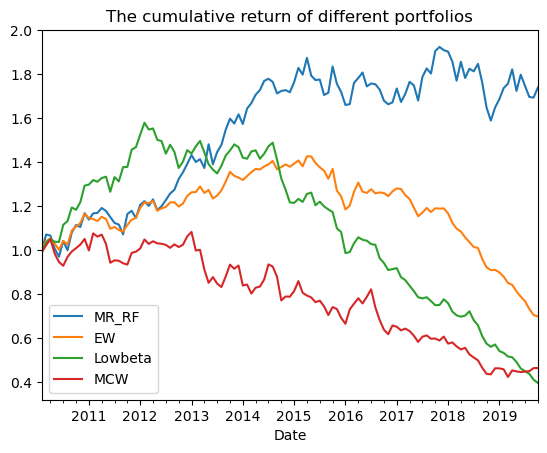

In [888]:
(df_portfolio.iloc[:,0:4]+1).cumprod().plot(title = "The cumulative return of different portfolios")
plt.show()

In [886]:
df_portfolio.mean()

MR_RF      0.005308
EW        -0.002784
Lowbeta   -0.007370
MCW       -0.005656
MVP       -1.431093
dtype: float64

In [887]:
df_portfolio.std()

MR_RF       0.033877
EW          0.023290
Lowbeta     0.031832
MCW         0.041909
MVP        15.019559
dtype: float64

The reason why MVP has so large standard deviation is because we did not add any constrain to its weights, thus its long and short weights can be unrealistic large

#### 4.2 With long-only constrains

In [889]:
from scipy.optimize import minimize

In [890]:
returns = df_SR.fillna(0)

In [891]:
# the objective function is to minimize the portfolio risk
def objective(weights): 
    weights = np.array(weights)
    return weights.dot(returns.cov()).dot(weights.T)
 
# The constraints
cons = (# The weights must sum up to one.
        {"type":"eq", "fun": lambda x: np.sum(x)-1}, 
        # This constraints says that the inequalities (ineq) must be non-negative.
        # The expected daily return of our portfolio and we want to be at greater than 0.003
        # {"type": "ineq", "fun": lambda x: np.sum(returns.mean()*x)-0.003}
        ) 
 
 
# Every stock can get any weight from 0 to 1
bounds = tuple((0,1) for x in range(returns.shape[1])) 
 
# Initialize the weights with an even split
guess = [1./returns.shape[1] for x in range(returns.shape[1])]
 
optimized_results = minimize(objective, guess, method = "SLSQP", bounds=bounds, constraints=cons)

In [892]:
optimized_results.x.reshape(-1,1)

array([[0.00000000e+00],
       [9.43042437e-19],
       [1.90274637e-19],
       [4.79620529e-03],
       [1.62630326e-19],
       [5.69639579e-03],
       [5.57805849e-03],
       [5.75982404e-19],
       [5.03233982e-19],
       [1.21401800e-02],
       [1.57912238e-03],
       [4.33012538e-03],
       [9.72449925e-03],
       [1.14902755e-03],
       [1.31344872e-03],
       [1.55517795e-03],
       [8.69948025e-04],
       [7.23715031e-20],
       [3.74191165e-19],
       [2.98238458e-19],
       [5.18186218e-19],
       [1.20015442e-18],
       [4.58185609e-07],
       [1.26463895e-02],
       [0.00000000e+00],
       [5.51967015e-20],
       [0.00000000e+00],
       [0.00000000e+00],
       [4.92884840e-04],
       [5.27281728e-03],
       [3.93023288e-19],
       [0.00000000e+00],
       [4.72505169e-03],
       [1.21401800e-02],
       [8.94652596e-03],
       [0.00000000e+00],
       [0.00000000e+00],
       [4.21191964e-03],
       [0.00000000e+00],
       [7.87357729e-04],


In [893]:
# it is expected to be 1
np.sum(optimized_results.x)

1.0

In [894]:
# the expected return of the portfolio
np.sum(returns.mean()*optimized_results.x)

-0.0006206286729488473

In [895]:
# report the final optimized weights
pd.DataFrame(list(zip(returns.columns, optimized_results.x)), columns=['Symbol', 'Weight']).T

,0,1,2,3,4,5,6,7,8,9,...,312,313,314,315,316,317,318,319,320,321
Symbol,4SI:XJSE:EQU,ABG:XJSE:EQU,APF:XJSE:EQU,ACS:XJSE:EQU,AIP:XJSE:EQU,ADR:XJSE:EQU,AVL:XJSE:EQU,ADH:XJSE:EQU,AFE:XJSE:EQU,ANI:XJSE:EQU,...,VKE:XJSE:EQU,VUN:XJSE:EQU,WEZ:XJSE:EQU,WEA:XJSE:EQU,WBO:XJSE:EQU,WHL:XJSE:EQU,WKF:XJSE:EQU,YYLBEE:XJSE:EQU,YRK:XJSE:EQU,ZED:XJSE:EQU
Weight,0.0,0.0,0.0,0.004796,0.0,0.005696,0.005578,0.0,0.0,0.01214,...,0.000236,0.0,0.0,0.0,0.0,0.0,0.000011,0.000815,0.0,0.0


Generalized the Procedure

In [896]:
def objective(wght): 
    wght = np.array(wght)
    return wght.dot(tmp.cov()).dot(wght.T)

MVPL_wght = []

for i in range(periods):
    tmp = lookback_return_list[i][Ranks[i]["Low_Beta"]]
    tmp = tmp.apply(replacer) # replace consecutive 0s over 10 times with NAs
    tmp = tmp.loc[:, (tmp != 0).any(axis = 0)].astype(np.float64) # remove columns that full of 0s
    tmp = tmp.loc[:, (~np.isnan(tmp).any(axis=0))].astype(np.float64) # remove columns that contain any nas
    
    cons  = ({"type":"eq", "fun": lambda x: np.sum(x)-1}) # {"type": "ineq", "fun": lambda x: np.sum(returns.mean()*x)-0.003}
    bounds = tuple((0,1) for x in range(tmp.shape[1])) 
    guess = [1./tmp.shape[1] for x in range(tmp.shape[1])]

    wght = []
    wght = minimize(objective, guess, method = "SLSQP", bounds=bounds, constraints=cons)
    wght = wght.x
    wght = pd.DataFrame(wght, columns=["MVPL_wght"], index=tmp.columns)

    MVPL_wght.append(wght.T)

In [897]:
k = np.random.randint(0,periods-1)
print(k)
MVPL_wght[k]

26


,LAB:XJSE:EQU,PSV:XJSE:EQU,GFI:XJSE:EQU,AHL:XJSE:EQU,NCS:XJSE:EQU,TPC:XJSE:EQU,HAR:XJSE:EQU,HWA:XJSE:EQU,KBO:XJSE:EQU,ANG:XJSE:EQU,...,TDH:XJSE:EQU,ATI:XJSE:EQU,MTU:XJSE:EQU,EPS:XJSE:EQU,MLI:XJSE:EQU,ARH:XJSE:EQU,NT1:XJSE:EQU,COH:XJSE:EQU,ARI:XJSE:EQU,HIL:XJSE:EQU
MVPL_wght,1.338368e-19,4.376439e-18,1.464385e-18,0.0,0.0,0.0,0.0,0.03284,0.0,0.0,...,0.037776,0.0,0.011352,0.018416,0.055199,0.064524,0.013373,0.071213,0.014934,0.089895


In [898]:
MVPL = list(map(hld_period_calcs2,holding_return_list, Ranks, MVPL_wght))

In [899]:
df_portfolio["MVPL"] = np.concatenate(MVPL)
df_portfolio

,MR_RF,EW,Lowbeta,MCW,MVP,MVPL
Date,,,,,,
2010-02,-0.0000,0.0131,-0.0008,-0.0094,0.1024,0.0276
2010-03,0.0715,0.0280,0.0361,0.0322,0.1753,0.0805
2010-04,-0.0044,0.0118,0.0160,0.0275,-0.0107,0.0268
2010-05,-0.0561,-0.0224,-0.0127,-0.0628,0.1078,-0.0620
2010-06,-0.0360,-0.0276,-0.0009,-0.0386,0.1092,0.0047
...,...,...,...,...,...,...
2019-06,0.0429,-0.0296,-0.0605,-0.0065,-0.0723,0.0027
2019-07,-0.0283,-0.0256,-0.0260,0.0045,0.2681,0.0017
2019-08,-0.0287,-0.0462,-0.0267,0.0042,0.0698,-0.0492


In [900]:
(df_portfolio.iloc[:,0:6]+1).cumprod()

,MR_RF,EW,Lowbeta,MCW,MVP,MVPL
Date,,,,,,
2010-02,1.000000,1.013100,0.999200,0.990600,1.102400,1.027600
2010-03,1.071500,1.041467,1.035271,1.022497,1.295651,1.110322
2010-04,1.066785,1.053756,1.051835,1.050616,1.281787,1.140078
2010-05,1.006939,1.030152,1.038477,0.984637,1.419964,1.069394
2010-06,0.970689,1.001720,1.037543,0.946630,1.575024,1.074420
...,...,...,...,...,...,...
2019-06,1.798454,0.788581,0.462066,0.445996,-7.781288,1.378749
2019-07,1.747558,0.768393,0.450052,0.448003,-9.867452,1.381093
2019-08,1.697403,0.732894,0.438036,0.449885,-10.556200,1.313143


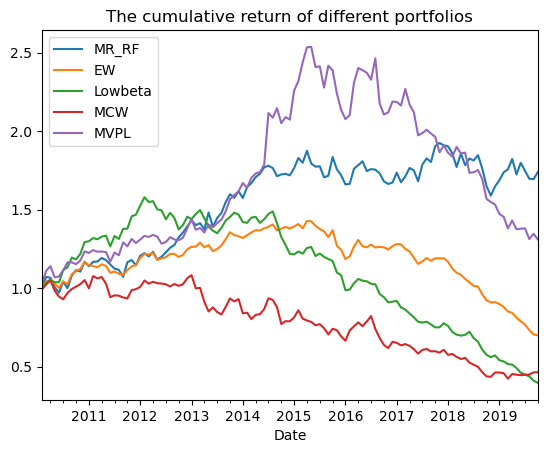

In [901]:
(df_portfolio.iloc[:, df_portfolio.columns != "MVP"]+1).cumprod().plot(title = "The cumulative return of different portfolios")
plt.show()

### 5. Equal Risk Contribution (ERC)

In [929]:
# risk budgeting optimization
def calculate_portfolio_var(w,V):
    # function that calculates portfolio risk
    w = np.matrix(w)
    return (w*V*w.T)[0,0]

def calculate_risk_contribution(w,V):
    # function that calculates asset contribution to total risk
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # Marginal Risk Contribution
    MRC = V*w.T
    # Risk Contribution
    RC = np.multiply(MRC,w.T)/sigma
    return RC

def risk_budget_objective(x,pars):
    # calculate portfolio risk
    V = pars[0]# covariance table
    x_t = pars[1] # risk target in percent of portfolio risk
    sig_p =  np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p,x_t))
    asset_RC = calculate_risk_contribution(x,V)
    J = sum(np.square(asset_RC-risk_target.T))[0,0]*1000 # sum of squared error
    return J

def total_weight_constraint(x):
    return np.sum(x)-1.0

def long_only_constraint(x):
    return x

ERC_wght = []

for i in range(periods):
    tmp = lookback_return_list[i][Ranks[i]["Low_Beta"]]
    tmp = tmp.apply(replacer) # replace consecutive 0s over 10 times with NAs
    tmp = tmp.loc[:, (tmp != 0).any(axis = 0)].astype(np.float64) # remove columns that full of 0s
    tmp = tmp.loc[:, (~np.isnan(tmp).any(axis=0))].astype(np.float64) # remove columns that contain any nas
    
    cons  = ({'type': 'eq', 'fun': total_weight_constraint}, {'type': 'ineq', 'fun': long_only_constraint})
    bounds = tuple((0,1) for x in range(tmp.shape[1])) 
    guess = [1./tmp.shape[1] for x in range(tmp.shape[1])] # Initialized weights for all assets
    x_t = [1./tmp.shape[1] for x in range(tmp.shape[1])] # your risk budget percent of total portfolio risk (equal risk)
    
    V = np.asmatrix(tmp.cov()) # use the original covariance matrix

    # V = np.diag(tmp.cov()) # extract the diagnol values
    # dgnl_mtr = np.zeros((tmp.shape[1],tmp.shape[1]))
    # np.fill_diagonal(dgnl_mtr, V)
    # V = np.asmatrix(dgnl_mtr) # use only the diagnol of covariance matrix

    wght = []
    wght = minimize(risk_budget_objective, guess, args=[V,x_t], method='SLSQP',constraints=cons, bounds = bounds, options={'disp': False})
    wght = wght.x
    wght = pd.DataFrame(wght, columns=["ERC_wght"], index=tmp.columns)

    ERC_wght.append(wght.T)

In [903]:
k = np.random.randint(0,periods-1)
print(k)
ERC_wght[k]

15


,FSEO1:XJSE:DER,LAB:XJSE:EQU,ADW:XJSE:EQU,PMV:XJSE:EQU,MSP:XJSE:EQU,CAC:XJSE:EQU,WKF:XJSE:EQU,UAT:XJSE:EQU,OCT:XJSE:EQU,HYP:XJSE:EQU,...,DSY:XJSE:EQU,MFL:XJSE:EQU,RLO:XJSE:EQU,ARL:XJSE:EQU,FTA:XJSE:EQU,GPL:XJSE:EQU,ARH:XJSE:EQU,PSV:XJSE:EQU,PBG:XJSE:EQU,BRT:XJSE:EQU
ERC_wght,0.002783,0.004886,0.005417,0.005274,0.006365,0.007363,0.010262,0.026915,0.009793,0.012079,...,0.039975,0.064749,0.028822,0.03104,0.071297,0.034549,0.03216,0.059212,0.030323,0.041447


In [904]:
ERC = list(map(hld_period_calcs2,holding_return_list, Ranks, ERC_wght))

In [905]:
df_portfolio["ERC"] = np.concatenate(ERC)
df_portfolio

,MR_RF,EW,Lowbeta,MCW,MVP,MVPL,ERC
Date,,,,,,,
2010-02,-0.0000,0.0131,-0.0008,-0.0094,0.1024,0.0276,0.0271
2010-03,0.0715,0.0280,0.0361,0.0322,0.1753,0.0805,0.0636
2010-04,-0.0044,0.0118,0.0160,0.0275,-0.0107,0.0268,0.0258
2010-05,-0.0561,-0.0224,-0.0127,-0.0628,0.1078,-0.0620,-0.0028
2010-06,-0.0360,-0.0276,-0.0009,-0.0386,0.1092,0.0047,0.0041
...,...,...,...,...,...,...,...
2019-06,0.0429,-0.0296,-0.0605,-0.0065,-0.0723,0.0027,-0.0397
2019-07,-0.0283,-0.0256,-0.0260,0.0045,0.2681,0.0017,-0.0120
2019-08,-0.0287,-0.0462,-0.0267,0.0042,0.0698,-0.0492,-0.0508


In [906]:
(df_portfolio.iloc[:,0:7]+1).cumprod()

,MR_RF,EW,Lowbeta,MCW,MVP,MVPL,ERC
Date,,,,,,,
2010-02,1.000000,1.013100,0.999200,0.990600,1.102400,1.027600,1.027100
2010-03,1.071500,1.041467,1.035271,1.022497,1.295651,1.110322,1.092424
2010-04,1.066785,1.053756,1.051835,1.050616,1.281787,1.140078,1.120608
2010-05,1.006939,1.030152,1.038477,0.984637,1.419964,1.069394,1.117470
2010-06,0.970689,1.001720,1.037543,0.946630,1.575024,1.074420,1.122052
...,...,...,...,...,...,...,...
2019-06,1.798454,0.788581,0.462066,0.445996,-7.781288,1.378749,0.855044
2019-07,1.747558,0.768393,0.450052,0.448003,-9.867452,1.381093,0.844783
2019-08,1.697403,0.732894,0.438036,0.449885,-10.556200,1.313143,0.801868


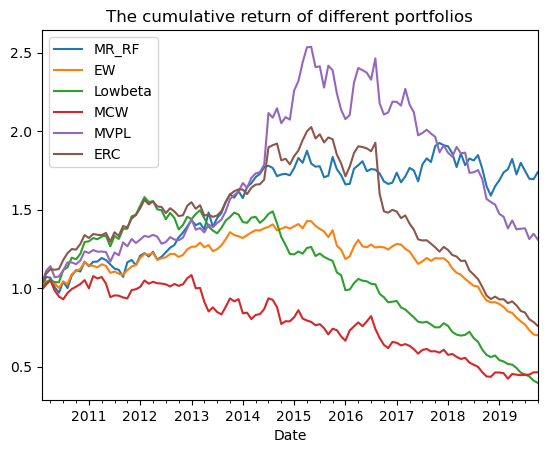

In [907]:
(df_portfolio.iloc[:, df_portfolio.columns != "MVP"]+1).cumprod().plot(title = "The cumulative return of different portfolios")
plt.show()

### 6. Naive Risk Parity (NRP)

In [908]:
NRP_wght = []

for i in range(periods):
    tmp = lookback_return_list[i][Ranks[i]["Low_Beta"]]
    tmp = tmp.apply(replacer) # replace consecutive 0s over 10 times with NAs
    tmp = tmp.loc[:, (tmp != 0).any(axis = 0)].astype(np.float64) # remove columns that full of 0s
    tmp = tmp.loc[:, (~np.isnan(tmp).any(axis=0))].astype(np.float64) # remove columns that contain any nas
    
    wght = pd.DataFrame((1/tmp.std())/np.sum((1/tmp.std())), columns=["NRP_wght"], index=tmp.columns)
    NRP_wght.append(wght.T)

In [909]:
NRP_wght[0]

,LAB:XJSE:EQU,CND:XJSE:EQU,JBL:XJSE:EQU,TKG:XJSE:EQU,AOVP:XJSE:EQU,HUG:XJSE:EQU,YRK:XJSE:EQU,ACT:XJSE:EQU,TON:XJSE:EQU,RBX:XJSE:EQU,...,BRT:XJSE:EQU,RES:XJSE:EQU,NCS:XJSE:EQU,NUT:XJSE:EQU,OCE:XJSE:EQU,JSC:XJSE:EQU,PMV:XJSE:EQU,MFL:XJSE:EQU,BLU:XJSE:EQU,EMI:XJSE:EQU
NRP_wght,0.005302,0.012019,0.008113,0.008684,0.013811,0.010433,0.011053,0.021084,0.032566,0.028838,...,0.052521,0.113929,0.033337,0.012041,0.028674,0.021387,0.027866,0.055552,0.029495,0.074292


In [910]:
NRP = list(map(hld_period_calcs2,holding_return_list, Ranks, NRP_wght))

In [911]:
df_portfolio["NRP"] = np.concatenate(NRP)
df_portfolio

,MR_RF,EW,Lowbeta,MCW,MVP,MVPL,ERC,NRP
Date,,,,,,,,
2010-02,-0.0000,0.0131,-0.0008,-0.0094,0.1024,0.0276,0.0271,0.0067
2010-03,0.0715,0.0280,0.0361,0.0322,0.1753,0.0805,0.0636,0.0484
2010-04,-0.0044,0.0118,0.0160,0.0275,-0.0107,0.0268,0.0258,0.0216
2010-05,-0.0561,-0.0224,-0.0127,-0.0628,0.1078,-0.0620,-0.0028,-0.0143
2010-06,-0.0360,-0.0276,-0.0009,-0.0386,0.1092,0.0047,0.0041,-0.0084
...,...,...,...,...,...,...,...,...
2019-06,0.0429,-0.0296,-0.0605,-0.0065,-0.0723,0.0027,-0.0397,-0.0485
2019-07,-0.0283,-0.0256,-0.0260,0.0045,0.2681,0.0017,-0.0120,-0.0137
2019-08,-0.0287,-0.0462,-0.0267,0.0042,0.0698,-0.0492,-0.0508,-0.0406


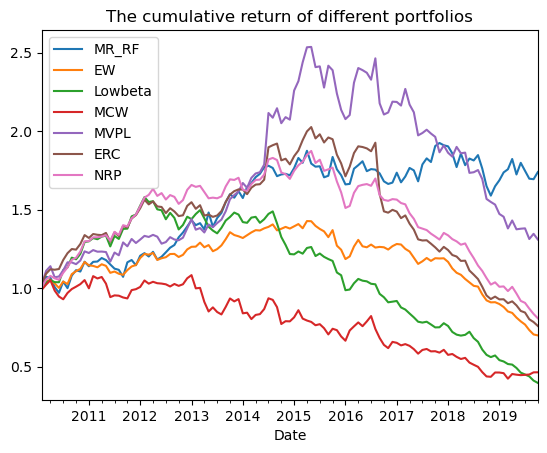

In [912]:
(df_portfolio.iloc[:, df_portfolio.columns != "MVP"]+1).cumprod().plot(title = "The cumulative return of different portfolios")
plt.show()

### 7. Maximum Diversification Portfolio (MDP)

In [913]:
def calc_diversification_ratio(w, V):
    # average weighted risk (sigma)
    w_vol = np.dot(np.sqrt(np.diag(V)), w.T)
    # portfolio risk (sigma)
    port_vol = np.sqrt(calculate_portfolio_var(w, V))
    diversification_ratio = w_vol/port_vol
    # return negative for minimization problem (maximize = minimize -)
    return -diversification_ratio # to minize this negative diversification_ratio is the same as to maximize the diversification_ratio


def max_div_port(w0, V, bounds, long_only=True):
    # w0: initial weight
    # V: covariance matrix
    # bnd: individual position limit
    # long only: long only constraint
    cons = ({'type': 'eq', 'fun': total_weight_constraint},)
    if long_only: # add in long only constraint
        cons = cons + ({'type': 'ineq', 'fun':  long_only_constraint},)
    res = minimize(calc_diversification_ratio, w0, bounds=bounds, args=V, method='SLSQP', constraints=cons)
    return res

MDP_wght = []

for i in range(periods):
    tmp = lookback_return_list[i][Ranks[i]["Low_Beta"]]
    tmp = tmp.apply(replacer) # replace consecutive 0s over 10 times with NAs
    tmp = tmp.loc[:, (tmp != 0).any(axis = 0)].astype(np.float64) # remove columns that full of 0s
    tmp = tmp.loc[:, (~np.isnan(tmp).any(axis=0))].astype(np.float64) # remove columns that contain any nas
    
    bounds = tuple((0,1) for x in range(tmp.shape[1])) 
    w0 = [1./tmp.shape[1] for x in range(tmp.shape[1])] # Initialized weights for all assets
    V = np.asmatrix(tmp.cov()) # use the original covariance matrix

    wght = []
    wght = max_div_port(w0, V, bounds=bounds, long_only=True)
    wght = wght.x
    wght = pd.DataFrame(wght, columns=["MDP_wght"], index=tmp.columns)

    MDP_wght.append(wght.T)

In [914]:
k = np.random.randint(0,periods-1)
print(k)
MDP_wght[k]

8


,PPR:XJSE:EQU,ADW:XJSE:EQU,SEB:XJSE:EQU,AHL:XJSE:EQU,MFL:XJSE:EQU,FGL:XJSE:EQU,EMH:XJSE:EQU,AON:XJSE:EQU,PMV:XJSE:EQU,GPL:XJSE:EQU,...,CKS:XJSE:EQU,PSV:XJSE:EQU,TDH:XJSE:EQU,RTO:XJSE:EQU,HUG:XJSE:EQU,ART:XJSE:EQU,OLG:XJSE:EQU,RTN:XJSE:EQU,EOH:XJSE:EQU,ENX:XJSE:EQU
MDP_wght,0.0,0.0,0.0,0.0,0.0,0.09157,0.0,0.0,0.143215,0.0,...,0.0,0.033715,0.0,0.0,0.114496,0.0,0.0,1.628035e-12,0.0,0.538601


In [915]:
MDP = list(map(hld_period_calcs2,holding_return_list, Ranks, MDP_wght))

In [916]:
df_portfolio["MDP"] = np.concatenate(MDP)
df_portfolio

,MR_RF,EW,Lowbeta,MCW,MVP,MVPL,ERC,NRP,MDP
Date,,,,,,,,,
2010-02,-0.0000,0.0131,-0.0008,-0.0094,0.1024,0.0276,0.0271,0.0067,0.0447
2010-03,0.0715,0.0280,0.0361,0.0322,0.1753,0.0805,0.0636,0.0484,0.0936
2010-04,-0.0044,0.0118,0.0160,0.0275,-0.0107,0.0268,0.0258,0.0216,0.0369
2010-05,-0.0561,-0.0224,-0.0127,-0.0628,0.1078,-0.0620,-0.0028,-0.0143,-0.0647
2010-06,-0.0360,-0.0276,-0.0009,-0.0386,0.1092,0.0047,0.0041,-0.0084,0.0057
...,...,...,...,...,...,...,...,...,...
2019-06,0.0429,-0.0296,-0.0605,-0.0065,-0.0723,0.0027,-0.0397,-0.0485,0.0004
2019-07,-0.0283,-0.0256,-0.0260,0.0045,0.2681,0.0017,-0.0120,-0.0137,-0.1193
2019-08,-0.0287,-0.0462,-0.0267,0.0042,0.0698,-0.0492,-0.0508,-0.0406,0.0819


In [917]:
(df_portfolio+1).cumprod()

,MR_RF,EW,Lowbeta,MCW,MVP,MVPL,ERC,NRP,MDP
Date,,,,,,,,,
2010-02,1.000000,1.013100,0.999200,0.990600,1.102400,1.027600,1.027100,1.006700,1.044700
2010-03,1.071500,1.041467,1.035271,1.022497,1.295651,1.110322,1.092424,1.055424,1.142484
2010-04,1.066785,1.053756,1.051835,1.050616,1.281787,1.140078,1.120608,1.078221,1.184642
2010-05,1.006939,1.030152,1.038477,0.984637,1.419964,1.069394,1.117470,1.062803,1.107995
2010-06,0.970689,1.001720,1.037543,0.946630,1.575024,1.074420,1.122052,1.053875,1.114311
...,...,...,...,...,...,...,...,...,...
2019-06,1.798454,0.788581,0.462066,0.445996,-7.781288,1.378749,0.855044,0.919042,0.622259
2019-07,1.747558,0.768393,0.450052,0.448003,-9.867452,1.381093,0.844783,0.906452,0.548023
2019-08,1.697403,0.732894,0.438036,0.449885,-10.556200,1.313143,0.801868,0.869650,0.592906


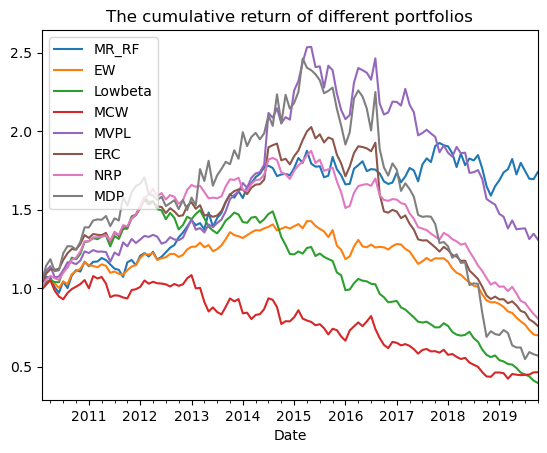

In [918]:
(df_portfolio.iloc[:, df_portfolio.columns != "MVP"]+1).cumprod().plot(title = "The cumulative return of different portfolios")
plt.show()

Sharpe Ratio

In [1091]:
pd.DataFrame(df_portfolio.apply(lambda x: x.mean()/x.std())).T

,MR_RF,EW,Lowbeta,MCW,MVP,MVPL,ERC,NRP,MDP
0,0.156674,-0.119526,-0.231533,-0.134967,-0.095282,0.077362,-0.053035,-0.052349,-0.052315


Treynor Ratio

In [1068]:
import statsmodels.api as sm

In [1107]:
betas = df_portfolio.drop('MR_RF', axis=1).apply(lambda x: sm.OLS(endog=x,
                                     exog=sm.add_constant(df_portfolio.loc[:,'MR_RF']))
                .fit(params_only=True)
                .params
                .drop('const'))
betas

,EW,Lowbeta,MCW,MVP,MVPL,ERC,NRP,MDP
MR_RF,0.466528,0.354036,0.432974,34.011179,0.371756,0.316972,0.29865,0.435592


In [1109]:
df_portfolio.drop('MR_RF',axis=1).mean()/betas

,EW,Lowbeta,MCW,MVP,MVPL,ERC,NRP,MDP
MR_RF,-0.005967,-0.020817,-0.013064,-0.042077,0.008316,-0.005617,-0.004828,-0.007011


### 8. Maximum Sharpe Ratio (MSR)

In [1025]:
np.matmul(calculate_portfolio_mean(w0,Returns), w0) 

ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [ ]:
def calculate_portfolio_var(w,V):
    # function that calculates portfolio risk
    w = np.matrix(w)
    return (w*V*w.T)[0,0]

def calculate_portfolio_mean(w,Returns):
    w = np.matrix(w)
    Mean_Returns = np.matrix(Returns.mean())
    return (w*Mean_Returns.T)[0,0]

# define maximization of Sharpe Ratio using principle of duality
def f_objective(x,pars):
    V = pars[0]
    Returns = pars[1]
    Denomr = np.sqrt(calculate_portfolio_var(x,V))
    Numer = np.matmul(calculate_portfolio_mean(x,Returns), x.T) 
    func = -(Denomr/Numer)
    return func

def risk_budget_objective(x,pars):
    # calculate portfolio risk
    V = pars[0]# covariance table
    x_t = pars[1] # risk target in percent of portfolio risk
    sig_p =  np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p,x_t))
    asset_RC = calculate_risk_contribution(x,V)
    J = sum(np.square(asset_RC-risk_target.T))[0,0]*1000 # sum of squared error
    return J

# def f(x, MeanReturns, CovarReturns, RiskFreeRate, PortfolioSize):
#     funcDenomr = np.sqrt(np.matmul(np.matmul(x, CovarReturns), x.T) )
#     funcNumer = np.matmul(np.array(MeanReturns),x.T)-RiskFreeRate
#     func = -(funcNumer / funcDenomr)
#     return func

def total_weight_constraint(x):
    return np.sum(x)-1.0

def long_only_constraint(x):
    return x


In [1032]:
MSR_wght = []

for i in range(periods):
    tmp = lookback_return_list[i][Ranks[i]["Low_Beta"]]
    tmp = tmp.apply(replacer) # replace consecutive 0s over 10 times with NAs
    tmp = tmp.loc[:, (tmp != 0).any(axis = 0)].astype(np.float64) # remove columns that full of 0s
    tmp = tmp.loc[:, (~np.isnan(tmp).any(axis=0))].astype(np.float64) # remove columns that contain any nas

    #define bounds and other parameters
    Returns = tmp
    V = np.asmatrix(tmp.cov()) # use the original covariance matrix

    w0 = np.asarray([1./tmp.shape[1] for x in range(tmp.shape[1])])
    cons = ({'type': 'eq', 'fun': total_weight_constraint}, {'type': 'ineq', 'fun': long_only_constraint})
    bnds = tuple((0,1) for x in range(tmp.shape[1])) 

    wght = []
    wght = minimize(f_objective, w0, args=[V,Returns], method='SLSQP',constraints=cons, bounds = bnds, tol = 10**-3, options={'disp': False})
    wght = wght.x
    wght = pd.DataFrame(wght, columns=["MSR_wght"], index=tmp.columns)

    MSR_wght.append(wght.T)

/Users/runxinlin/opt/anaconda3/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = N.array(data, dtype=dtype, copy=copy)


ValueError: shapes (1,34) and (1,2) not aligned: 34 (dim 1) != 1 (dim 0)

In [ ]:
# risk budgeting optimization
def calculate_portfolio_var(w,V):
    # function that calculates portfolio risk
    w = np.matrix(w)
    return (w*V*w.T)[0,0]

def calculate_risk_contribution(w,V):
    # function that calculates asset contribution to total risk
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # Marginal Risk Contribution
    MRC = V*w.T
    # Risk Contribution
    RC = np.multiply(MRC,w.T)/sigma
    return RC

def risk_budget_objective(x,pars):
    # calculate portfolio risk
    V = pars[0]# covariance table
    x_t = pars[1] # risk target in percent of portfolio risk
    sig_p =  np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p,x_t))
    asset_RC = calculate_risk_contribution(x,V)
    J = sum(np.square(asset_RC-risk_target.T))[0,0]*1000 # sum of squared error
    return J

def total_weight_constraint(x):
    return np.sum(x)-1.0

def long_only_constraint(x):
    return x

ERC_wght = []

for i in range(periods):
    tmp = lookback_return_list[i][Ranks[i]["Low_Beta"]]
    tmp = tmp.apply(replacer) # replace consecutive 0s over 10 times with NAs
    tmp = tmp.loc[:, (tmp != 0).any(axis = 0)].astype(np.float64) # remove columns that full of 0s
    tmp = tmp.loc[:, (~np.isnan(tmp).any(axis=0))].astype(np.float64) # remove columns that contain any nas
    
    cons  = ({'type': 'eq', 'fun': total_weight_constraint}, {'type': 'ineq', 'fun': long_only_constraint})
    bounds = tuple((0,1) for x in range(tmp.shape[1])) 
    guess = [1./tmp.shape[1] for x in range(tmp.shape[1])] # Initialized weights for all assets
    x_t = [1./tmp.shape[1] for x in range(tmp.shape[1])] # your risk budget percent of total portfolio risk (equal risk)
    
    V = np.asmatrix(tmp.cov()) # use the original covariance matrix

    # V = np.diag(tmp.cov()) # extract the diagnol values
    # dgnl_mtr = np.zeros((tmp.shape[1],tmp.shape[1]))
    # np.fill_diagonal(dgnl_mtr, V)
    # V = np.asmatrix(dgnl_mtr) # use only the diagnol of covariance matrix

    wght = []
    wght = minimize(risk_budget_objective, guess, args=[V,x_t], method='SLSQP',constraints=cons, bounds = bounds, options={'disp': True})
    wght = wght.x
    wght = pd.DataFrame(wght, columns=["ERC_wght"], index=tmp.columns)

    ERC_wght.append(wght.T)